In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes, remove_small_objects, disk, opening, closing
import glob
import pathlib
import math

In [174]:
rpi = 'h2r4'

# Read input image and resize them
path_to_folder = '../live_bees/' + rpi + '/random_images_25/*.jpg'
folder_in = sorted(glob.glob(path_to_folder))
names = [pathlib.Path(x).stem for x in folder_in]
imgs = [cv2.imread(x) for x in folder_in]
folder_out = 'resized_images/' + rpi + '/'
n = 0
#uncomment to resize images if you dont have them
for img_path in folder_in:
    cv2.imwrite(folder_out + str(names[n]) + '.jpg', cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY), (0,0), fx=0.5, fy=0.5));
    n += 1

resized_imgs = [cv2.imread(x) for x in sorted(glob.glob(folder_out + '*.jpg'))]

output_folder = '../a_processed_images/region_growing/' + rpi + '/' 

In [175]:
def rgb2gray(bgr):
    return np.dot(bgr[...,:3], [0.1140, 0.5870, 0.2989])

def region_growing(image, seed_point, visited, mask, threshold, value_threshold, max_iterations=10000):
    # Get image dimensions
    rows, cols = image.shape[:2]
    # Initialize queue for pixels to visit
    queue = []
    queue.append(seed_point)
    iterations = 0
    # Define 4-connectivity neighbors
    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    while queue: # and iterations < max_iterations:
        iterations += 1
        # Get current pixel from queue
        current_point = queue.pop(0)
        mask[current_point] = 1
        visited[current_point] = 1

        for neighbor in neighbors:
            # Calculate neighbor coordinates
            x_neighbor, y_neighbor = current_point[0] + neighbor[0], current_point[1] + neighbor[1]

            # Check if neighbor is within image bounds
            if 0 <= x_neighbor < rows and 0 <= y_neighbor < cols:
                # Check if neighbor pixel is not visited
                if visited[x_neighbor, y_neighbor] == 0: #and (rgb2gray(image[x_neighbor, y_neighbor]) < value_threshold):
                    # Calculate gradient descent
                    gradient = abs(int(rgb2gray(image[current_point])) - int(rgb2gray(image[x_neighbor, y_neighbor])))
                    # Check if gradient is less than threshold
                    if gradient <= threshold:
                        queue.append((x_neighbor, y_neighbor))
                        visited[x_neighbor, y_neighbor] = 1

In [189]:
# Set threshold for region growing
if rpi == 'h2r1': value_threshold, gradient_threshold = 50, 2
if rpi == 'h2r2': value_threshold, gradient_threshold = 55, 2
if rpi == 'h2r3': value_threshold, gradient_threshold = 56, 1
if rpi == 'h2r4': value_threshold, gradient_threshold = 45, 1
masks = []
n = 0

for input_image in resized_imgs:
    rows, cols = input_image.shape[:2]
    # Initialize visited matrix, taking only the first 2 dimensions of the input image
    visited = np.zeros((input_image.shape[0], input_image.shape[1]))
    mask = np.zeros((input_image.shape[0], input_image.shape[1]))
    # Perform region growing
    for x in range(rows):
        for y in range(cols):
            if (visited[x, y] == 0) and (rgb2gray(input_image[x, y]) < value_threshold):
                region_growing(input_image, (x, y), visited, mask, gradient_threshold, value_threshold)
    mask = closing(opening(mask, disk(3)), disk(3))
    masks.append(mask)
    cv2.imwrite(output_folder + names[n] + '_final_mask.jpg', mask * 255)
    n += 1
    

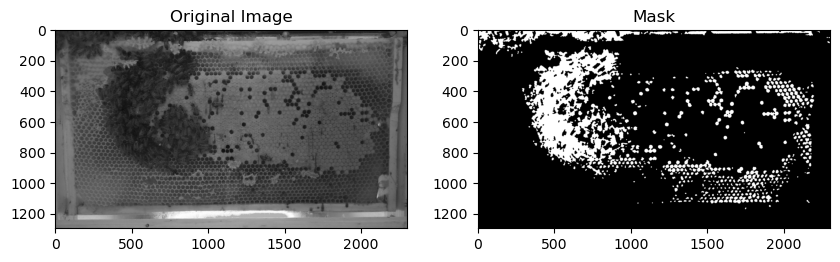

In [188]:
#plot the resized_imgs next to the mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(resized_imgs[0], cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(masks[0], cmap='gray')
axs[1].set_title('Mask')
plt.show()